In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load dataset
file_path = "ttc-bus-delay_final_cleaned_data_All.csv"
df = pd.read_csv(file_path)

In [3]:
# Convert date columns into proper datetime
df["date"] = pd.to_datetime(df[["year", "month", "date"]].astype(str).agg('-'.join, axis=1), errors="coerce")

In [4]:
# Separate full data for plotting later
full_actual_df = df[["date", "min delay"]].dropna()

In [5]:
# Filter data from 2019 to 2022 for training and testing
data = df[df["year"].between(2019, 2022)].copy()

In [6]:
# Feature engineering
data["hour"] = pd.to_datetime(data["time"], errors="coerce").dt.hour.fillna(0).astype(int)
data["weekday"] = data["date"].dt.weekday
data["month"] = data["date"].dt.month

In [7]:
# Encode categorical features
categorical_cols = ["route", "location", "incident"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

In [8]:
# One-hot encode 'day' and 'direction'
data = pd.get_dummies(data, columns=["day", "direction"], drop_first=True)

In [9]:
# Define features and targets
features = [col for col in data.columns if col not in ["min delay", "delay_type", "time", "date"]]
X = data[features]
y_cls = data["delay_type"]
y_reg = data["min delay"]

In [10]:
# Standardize
scaler = StandardScaler()
X[["hour"]] = scaler.fit_transform(X[["hour"]])

In [11]:
# Time-based split (80-20)
split_index = int(len(data) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train_cls, y_test_cls = y_cls[:split_index], y_cls[split_index:]
y_train_reg, y_test_reg = y_reg[:split_index], y_reg[split_index:]

In [12]:
# Train regression model
rf_reg = RandomForestRegressor(random_state=42)
grid_reg = GridSearchCV(rf_reg, {"n_estimators": [100, 200], "max_depth": [10, 20, None]}, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1)
grid_reg.fit(X_train, y_train_reg)
reg = grid_reg.best_estimator_

In [13]:
# Train classification model
rf_clf = RandomForestClassifier(random_state=42)
grid_clf = GridSearchCV(rf_clf, {"n_estimators": [100, 200], "max_depth": [10, 20, None]}, cv=3, scoring="accuracy", n_jobs=-1)
grid_clf.fit(X_train, y_train_cls)
clf = grid_clf.best_estimator_

In [14]:
# Evaluate
y_pred_cls = clf.predict(X_test)
y_pred_reg = reg.predict(X_test)

In [15]:
print(f"Classification Accuracy: {accuracy_score(y_test_cls, y_pred_cls)}")
print(f"Regression MAE: {mean_absolute_error(y_test_reg, y_pred_reg)}")
print("Classification Report:")
print(classification_report(y_test_cls, y_pred_cls))

Classification Accuracy: 0.9686926863798706
Regression MAE: 1.8973452846586774
Classification Report:
              precision    recall  f1-score   support

        long       0.97      0.81      0.88      1775
      medium       0.96      0.98      0.97     15150
       short       0.98      0.98      0.98     14154

    accuracy                           0.97     31079
   macro avg       0.97      0.92      0.94     31079
weighted avg       0.97      0.97      0.97     31079



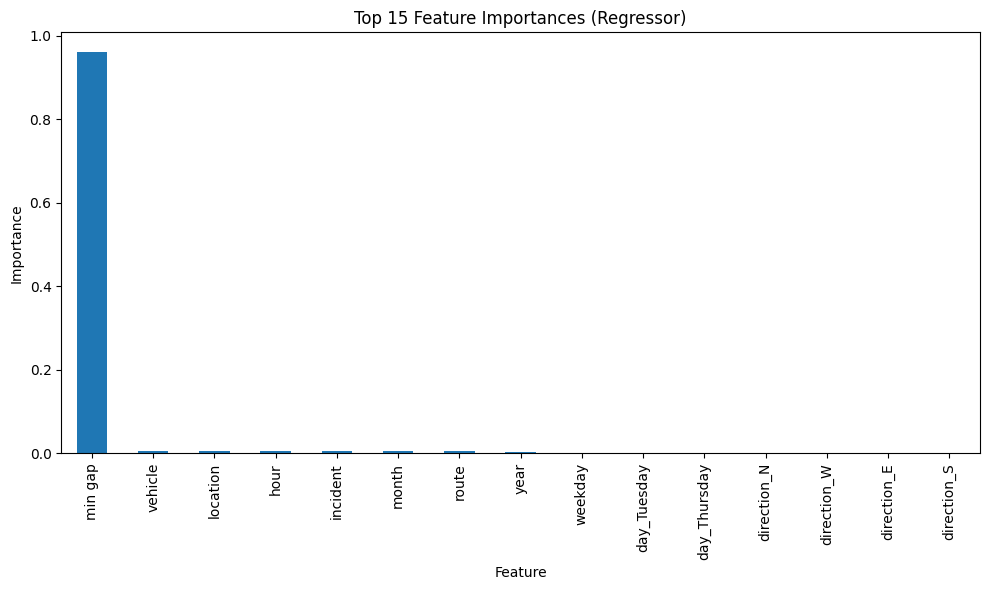

In [27]:
# Feature importances from the regression model
importances = pd.Series(reg.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
importances[:15].plot(kind='bar')
plt.title("Top 15 Feature Importances (Regressor)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [30]:
# Predict for 2023
future_data = df[df["date"].between("2023-01-01", "2023-12-31")].copy()
future_data["hour"] = pd.to_datetime(future_data["time"], errors="coerce").dt.hour.fillna(0).astype(int)
future_data["weekday"] = future_data["date"].dt.weekday
future_data["month"] = future_data["date"].dt.month

In [31]:
# Apply same label encoders
for col in categorical_cols:
    le = label_encoders[col]
    future_data[col] = future_data[col].astype(str)
    future_data[col] = future_data[col].apply(lambda x: x if x in le.classes_ else le.classes_[0])
    le.classes_ = np.append(le.classes_, list(set(future_data[col]) - set(le.classes_)))
    future_data[col] = le.transform(future_data[col])

In [32]:
# One-hot encode
future_data = pd.get_dummies(future_data, columns=["day", "direction"], drop_first=True)

In [33]:
# Align columns with training set
for col in X.columns:
    if col not in future_data:
        future_data[col] = 0
future_data = future_data[X.columns]  # Ensure same order


In [34]:
# Scale hour
future_data[["hour"]] = scaler.transform(future_data[["hour"]])

In [35]:
# Predict
future_data["date"] = df[df["date"].between("2023-01-01", "2023-12-31")]["date"].values
future_data["predicted_delay"] = reg.predict(future_data.drop(columns=["date"]))

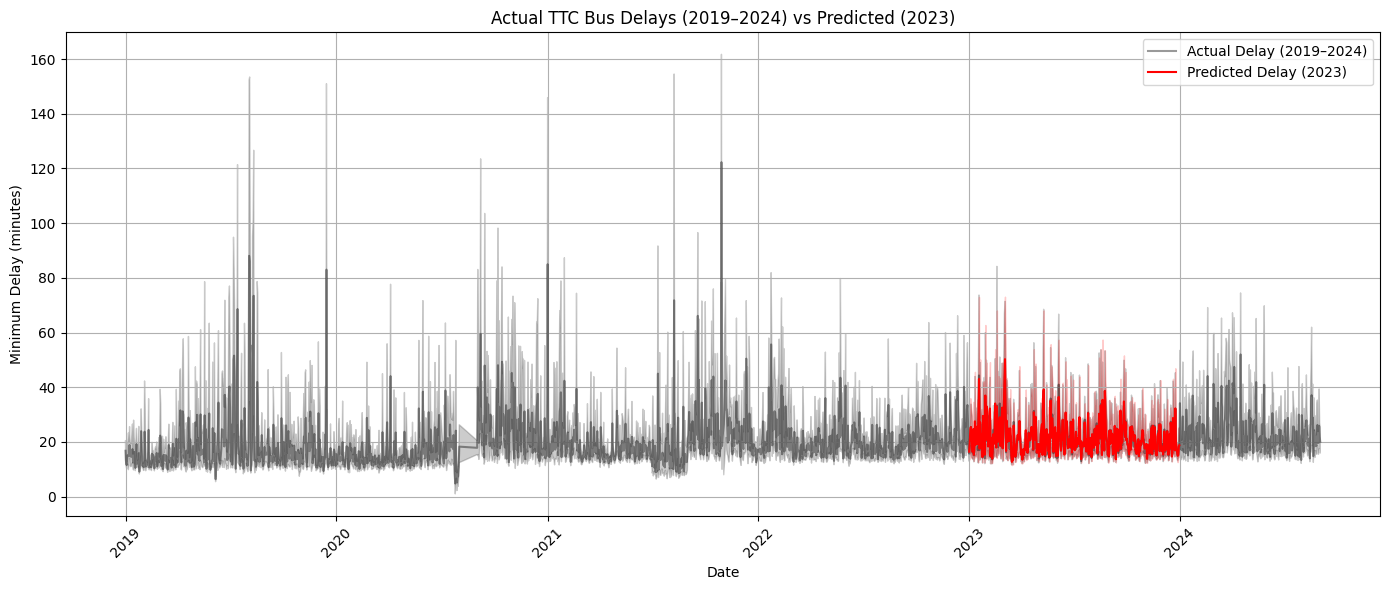

In [37]:
# Plot actual (2019–2024) and prediction (2023)
plt.figure(figsize=(14, 6), dpi=100)
sns.lineplot(data=full_actual_df, x="date", y="min delay", label="Actual Delay (2019–2024)", color="black", alpha=0.4)
sns.lineplot(data=future_data, x="date", y="predicted_delay", label="Predicted Delay (2023)", color="red")

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel("Date")
plt.ylabel("Minimum Delay (minutes)")
plt.title("Actual TTC Bus Delays (2019–2024) vs Predicted (2023)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()